## Figuras Omega Cent

En el siguiente notebook se han generado las imagenes del trabajo.

### Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import numpy as np
from dotenv import load_dotenv
from google.cloud import storage

import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


    
# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.sources.source import AstroMetricData, AstroObject
from hyper_velocity_stars_detection.jobs.utils import read_baumgardt_catalog
from hyper_velocity_stars_detection.tools.stadistics_utils import hist_sample
from hyper_velocity_stars_detection.tools.hvs_estimation import get_hvs_candidates
from hyper_velocity_stars_detection.tools.imbh_mass_estimation import v_ejections_sample, sample_mbh, estimate_log10_mbh_from_sigma
from hyper_velocity_stars_detection.tools.cluster_representations import get_best_isochrone_fitted, load_isochrone_from_parsec
from hyper_velocity_stars_detection.globular_clusters import GlobularClusterAnalysis
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_globular_cluster,load_astrometric_data
from hyper_velocity_stars_detection.variables_names import *

load_dotenv("../../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../data/hvs-storage.json"

PATH = "../../data/report_notebook"

RADIUS_SCALE = 1
CATALOG = "gaiadr3"
FILTERS = {"ast_params_solved": 3, "ruwe": 1.4, "v_periods_used": 10, "min_parallax": 0}
PROJECT = os.environ["PROJECT_ID"]
BUCKET = os.environ["BUCKET"]
BUCKET_PATH = "report/gc_clusters/"

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Descarga del cúmulo analizado

In [2]:
CLUSTER_NAME = "ngc 5139"

gc_object = load_globular_cluster(CLUSTER_NAME, PROJECT, BUCKET, BUCKET_PATH)
print(gc_object)

Muestras seleccionadas del objeto astronómico ngc 5139 con radio 1.0:
	 - df_c1 - Todas las estrellas seleccionadas: 122378.
	 - df_c2 - Las estrellas con errores de paralaje y pm menores al 10%: 15821.
	 - df_c3 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16508.
	 - df_c4 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 30%.: 16835.
Se han encontrado 10 fuentes de rayos X.
Estimated number of clusters: 6
Estimated number of noise points: 1489
	 - Volumen total del cluster 0: 357.
	 - Volumen total del cluster 1: 268.
	 - Volumen total del cluster 2: 2389.
	 - Volumen total del cluster 3: 32.
	 - Volumen total del cluster 4: 24.
	 - Volumen total del cluster 5: 441.



Descargamso los datos sin filtrar para estimar el volumen descartado.

In [3]:
astro_object = AstroObject.get_object("ngc 5139")
radius = astro_object.info["ANGULAR_SIZE"][0] / 60
df_tuc =  astro_object.download_data(
        radius=radius,
        catalog_name="gaiadr3",
        ast_params_solved=None,
        ruwe=None,
        v_periods_used=None
    )
df_tuc

KeyboardInterrupt: 

Comparamos las estrellas que se han descargado seleccionando las descartadas.

In [ ]:
df_data = gc_object.astro_data.get_data("df_c1")
df_descarted = df_tuc[~df_tuc.SOURCE_ID.isin(df_data.SOURCE_ID)]
df_descarted

Se calcula el número de estrellas descartadas dentro del radio $r$.

In [ ]:
def count_star(center: np.ndarray, df_data: pd.DataFrame, radio: float) -> int:
    distance = np.sqrt((df_data.l - center[0])**2 + (df_data.b - center[1])**2)
    distance = distance / distance.max()
    return (distance<radio).sum()

center = np.array([df_data.l.mean(), df_data.b.mean()])
count_star(center, df_descarted, 0.5)

radio_array = np.linspace(0, 1, 101)
original_stars = np.zeros(101)
descarted_stars = np.zeros(101)
for pos, radio in enumerate(radio_array):
    original_stars[pos] = count_star(center, df_tuc, radio)
    descarted_stars[pos] = count_star(center, df_descarted, radio)

ratio_descarted =descarted_stars/ df_descarted.shape[0]
ratio_descarted_2 =descarted_stars/ original_stars
#plt.plot(radio_array, ratio_descarted)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Descarte de estrellas 47 Tucanae")
ax[0].plot(radio_array, ratio_descarted, label="Fracción descarte.")
ax[0].fill_between(x=radio_array[radio_array<0.5], y1=0, y2=ratio_descarted[radio_array<0.5], color="k", alpha=0.25, label="r < 0.5")
ax[0].set_xlabel("Fracción del radio")
ax[0].set_ylabel("Fracción de estrellas descartada")
ax[0].legend()
ax[0].grid()


ax[1].plot(radio_array, ratio_descarted_2, label="Fracción descarte.")
mask = ratio_descarted_2 > 0.8
ax[1].fill_between(x=radio_array[mask], y1=0.48, y2=ratio_descarted_2[mask], color="k", alpha=0.25, label=f"r < {radio_array[mask].max():.2f}")
ax[1].set_xlabel("Fracción del radio")
ax[1].legend()
ax[1].grid()
plt.savefig("../figures/fraccion_descarte_omega_cent.png")


In [23]:
gc_object.describe()

,parallax,pmra,pmdec,bp_rp,phot_g_mean_mag
count,2389.000000,2389.000000,2389.000000,2389.000000,2389.000000
mean,0.193191,-3.275689,-6.727458,1.289234,13.653852
std,0.041928,0.475061,0.444651,0.164264,1.139685
min,0.044275,-5.031834,-8.504297,0.921968,10.707626
25%,0.168825,-3.595071,-7.017502,1.175050,12.831620
50%,0.191889,-3.270649,-6.724231,1.232787,13.887361
75%,0.217873,-2.954304,-6.444815,1.362339,14.531688
max,0.376807,-1.253129,-4.998868,1.884497,15.808732


## Figuras de la selección de estrellas del cluster

In [20]:
gc_object.clustering_results.main_label

2

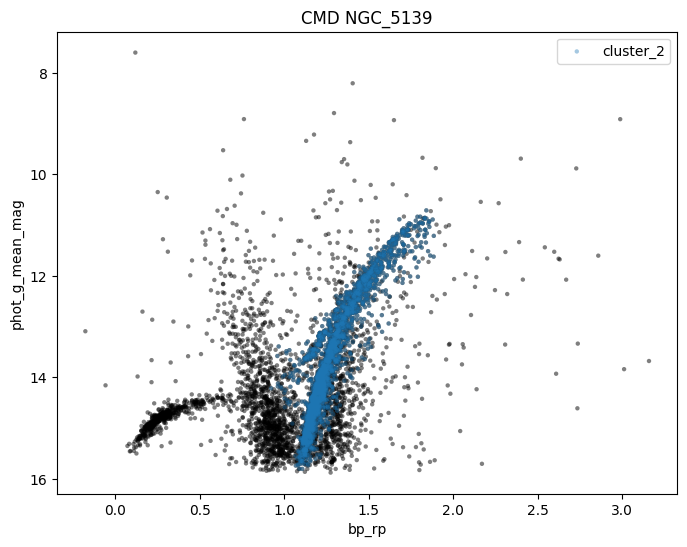

In [22]:
fig, ax = gc_object.plot_cmd(
    clusters=gc_object.clustering_results.main_label, 
    figsize=(8,6)
)
plt.legend()
plt.savefig("../figures/cmd_omega_cent.png")

## Distribución de masas de Omega Cent

In [5]:
df_gc = gc_object.clustering_results.remove_outliers_gc(random_state=123).copy()

df_gc["pmra_kms"] = df_gc["pmra_kms"] - df_gc["pmra_kms"].mean()
df_gc["pmdec_kms"] = df_gc["pmdec_kms"] - df_gc["pmdec_kms"].mean()
df_gc["radial_velocity"] = df_gc["radial_velocity"] - df_gc["radial_velocity"].mean()

df_gc["v_tan"] = np.sqrt(df_gc.pmra_kms**2 + df_gc.pmdec_kms**2)
df_gc["v_3d"] = np.sqrt(df_gc.v_tan**2 + df_gc.radial_velocity**2)
sigma_v = df_gc["v_3d"].std()
print("Estrellas con velocidad radial: %i" % (~df_gc["radial_velocity"].isna()).sum())
print("Dispersión de velocides calculadas: %f" % sigma_v)

Estrellas con velocidad radial: 1171
Dispersión de velocides calculadas: 22.634809


In [25]:
df_gc.pm.mean()

np.float64(7.488449583827612)

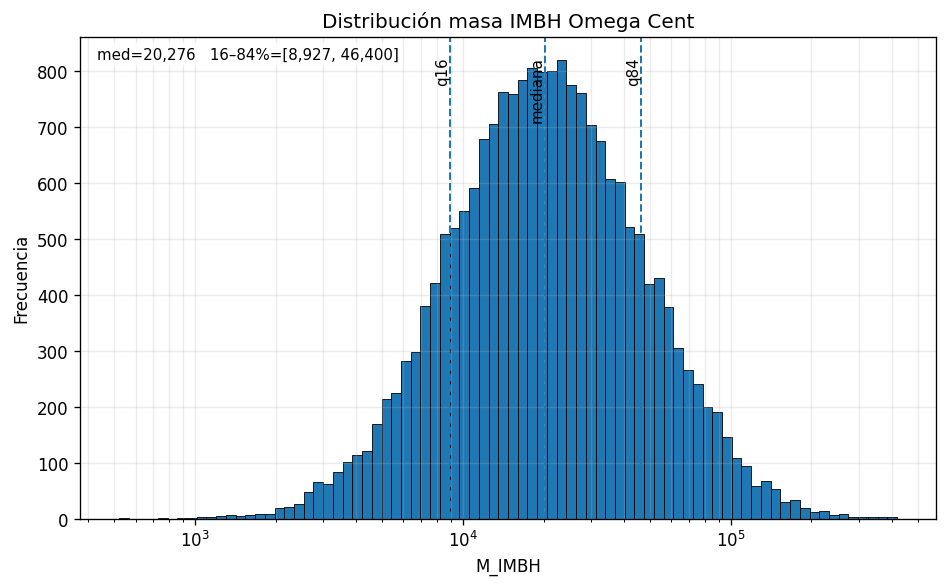

In [17]:
log10_mh, scatter_dex = estimate_log10_mbh_from_sigma(sigma_v)
imbh_sample = sample_mbh(log10_mh, scatter_dex, size=20000, seed=123)
hist_sample(imbh_sample, title="Distribución masa IMBH Omega Cent", xlabel="M_IMBH", ylabel="Frecuencia")
plt.savefig("../figures/imbh_distribution_omega_cent.png")

In [26]:
sigma_v

np.float64(22.634808831006424)

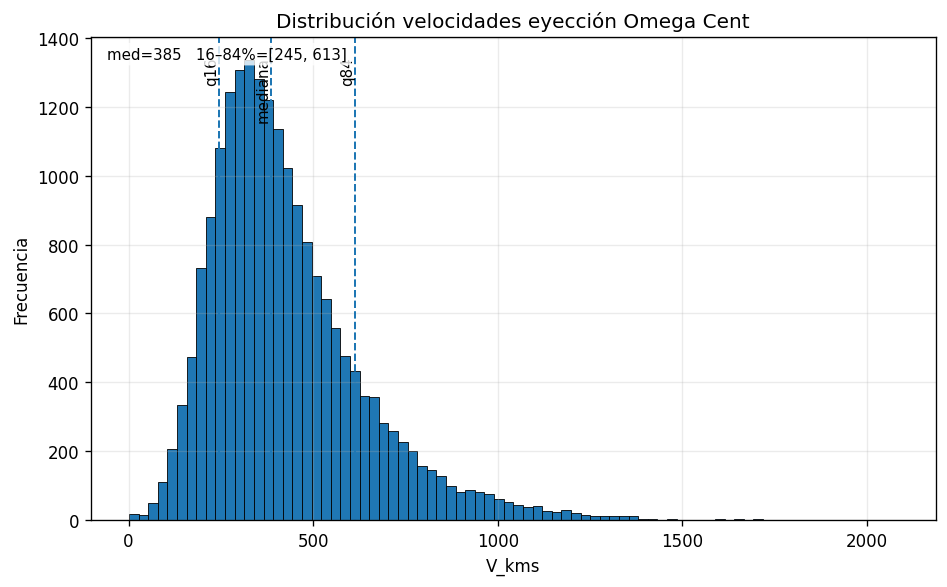

In [18]:
v_ej_sample = v_ejections_sample(
    a_space=(0.05,0.5),
    m_bin_space=(0.6, 1.7),
    sigma_kms=sigma_v,
    sigma_f=0.3,
    size=20000,
    seed=123
)

hist_sample(v_ej_sample, title="Distribución velocidades eyección Omega Cent", xlabel="V_kms", ylabel="Frecuencia", logx=False)
plt.savefig("../figures/v_eject_omega_cent.png")

(0, 159)


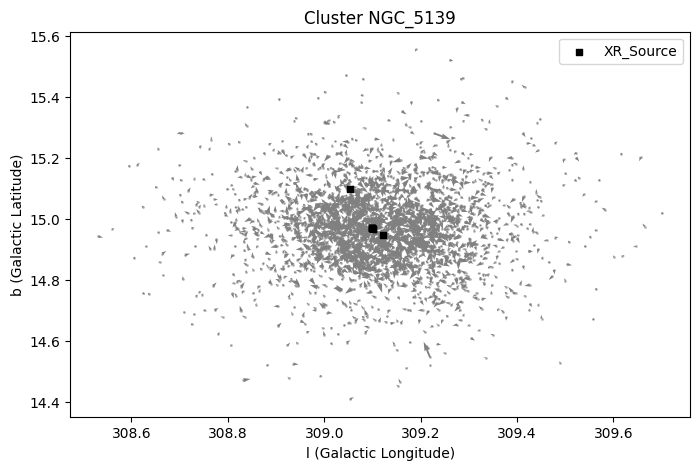

In [28]:
df_highlights_stars=get_hvs_candidates(gc_object, np.quantile(v_ej_sample, 0.84))

print(df_highlights_stars.shape)

fig, ax = gc_object.plot_cluster(highlight_stars=df_highlights_stars, factor_size=15)
plt.savefig("../figures/cluster_omega_cent.png")